In [1]:
import os

current_path = '/content/drive/My Drive/Colab Notebooks/Project_Stock/'
os.chdir(current_path)

### LOAD DATA

In [2]:
file_path = './Labeled_Data/Futures/'
files = os.listdir(file_path)
print(len(files))

1


### Load Data

In [26]:
import pandas as pd
import numpy as np


def min_max_scaler(x):
    scaled_x = (x - x.min()) / (x.max() - x.min())
    return scaled_x


def max_abs_scaler(x):
    scaled_x = x / abs(x).max()
    return scaled_x

#   # file = files[5]
ohlcv_excel = pd.read_excel(file_path + file, index_col=0)
# new_column = ['open', 'close', 'high', 'low', 'MA_SHORT', 'MA_LONG', 'SUPERTREND',
#                   'TRIX', 'MACD', 'MACD_Signal', 'MACD_OSC', 'FISHER_LONG', 'FISHER_LONGER',
#                   'STOCHASTIC_D', 'STOCHASTIC_D2', 'STOCH_RSI', 'STOCH_RSI2', 'STOCH_RSI3', 'label']
new_column = ['open', 'close', 'high', 'low', 'MA_SHORT', 'MA_LONG', 'SUPERTREND',
                  'TRIX_Histogram', 'MACD', 'MACD_Signal', 'MACD_OSC', 'FISHER_LONG',
                  'STOCHASTIC_D', 'STOCH_RSI', 'label']
ohlcv_excel = ohlcv_excel[new_column]
# ohlcv_excel = ohlcv_excel.fillna(3)
# print(ohlcv_excel.info())
# break

ohlcv_excel = ohlcv_excel.iloc[sum(ohlcv_excel['STOCH_RSI'].isna()):-1, :]
if sum(sum(np.isnan(ohlcv_excel.values[:, :]))) != 0:
    print('None value imported')
    print(sum(np.isnan(ohlcv_excel.values[:, :])))

    # print(ohlcv_excel.info())
    # quit()
    # ohlcv_excel.to_excel('test.xlsx')

# NaN 제외하고 데이터 자르기 (데이터가 PIXEL 로 들어간다고 생각하면 된다)
ohlcv_data = ohlcv_excel.values.astype(np.float)

#        PRICE MA SUPERTREND      #
# ohlcv_data[:, [0, 1, 2, 3, 4, 5, 6]] = min_max_scaler(ohlcv_data[:, [0, 1, 2, 3, 4, 5, 6]])
ohlcv_data[:, [0, 1, 2, 3, 4, 5, 6]] = max_abs_scaler(ohlcv_data[:, [0, 1, 2, 3, 4, 5, 6]])
# ohlcv_data[:, :4] = max_abs_scaler(ohlcv_data[:, :4])

#       TRIX / FISHER   7, 11    #
for column_number in [7, 11]:
    ohlcv_data[:, [column_number]] = max_abs_scaler(ohlcv_data[:, [column_number]])

#       STOCH SERIES     #
for column_number in [12, 13]:
    ohlcv_data[:, [column_number]] = max_abs_scaler(ohlcv_data[:, [column_number]])
w
#       MACD, SIGNAL, OSC   8, 9, 10      #
ohlcv_data[:, [8, 9]] = max_abs_scaler(ohlcv_data[:, [8, 9]])
ohlcv_data[:, [10]] = max_abs_scaler(ohlcv_data[:, [10]])

In [34]:
# X = ohlcv_data[:, :-1]
X = ohlcv_data[:, :4]
y = ohlcv_data[:, [-1]]
print(X.shape, y.shape)
y = y.reshape(-1, )
print(X.shape, y.shape)


(1469, 4) (1469, 1)
(1469, 4) (1469,)


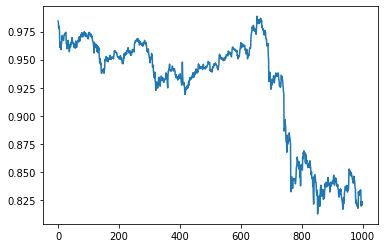

In [29]:
import matplotlib.pyplot as plt

plt.plot(X[:1000, [1]])
plt.show()

### PREDICTION

In [36]:
#import XGBoost classifier and accuracy
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')


# split data into train and test sets
seed = 7
test_size = 0.3
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


from sklearn.utils.testing import all_estimators
from sklearn.metrics import accuracy_score, classification_report

allAlgorithms = all_estimators(type_filter='classifier')

#       Check Best Perfomance Model     #
scores = list()
names = list()
for(name, algorithm) in allAlgorithms:

  try:
    clf = algorithm()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # print(accuracy_score(y_test, y_pred), name)
    names.append(name)
    scores.append(accuracy_score(y_test, y_pred))

  except Exception as e:
    print(e)

acc_series = pd.Series(index=names, data=scores).sort_values(ascending=False)
print(acc_series.head())



#         Use Best Model        #

best_model = 'ComplementNB'
# best_model = acc_series.index[0]

for name, model in allAlgorithms:
  if name == best_model:
    best_model = model()
    best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print(y_pred)
# print(accuracy_score(y_test, y_pred))

__init__() missing 1 required positional argument: 'base_estimator'
__init__() missing 1 required positional argument: 'estimator'
__init__() missing 1 required positional argument: 'estimator'
__init__() missing 1 required positional argument: 'estimator'
__init__() missing 1 required positional argument: 'estimator'
__init__() missing 1 required positional argument: 'estimators'
__init__() missing 1 required positional argument: 'estimators'
ComplementNB                  0.575964
LinearDiscriminantAnalysis    0.569161
LogisticRegressionCV          0.555556
BaggingClassifier             0.546485
RidgeClassifierCV             0.541950
dtype: float64
[1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1

(1243, 4) (1243, 1)


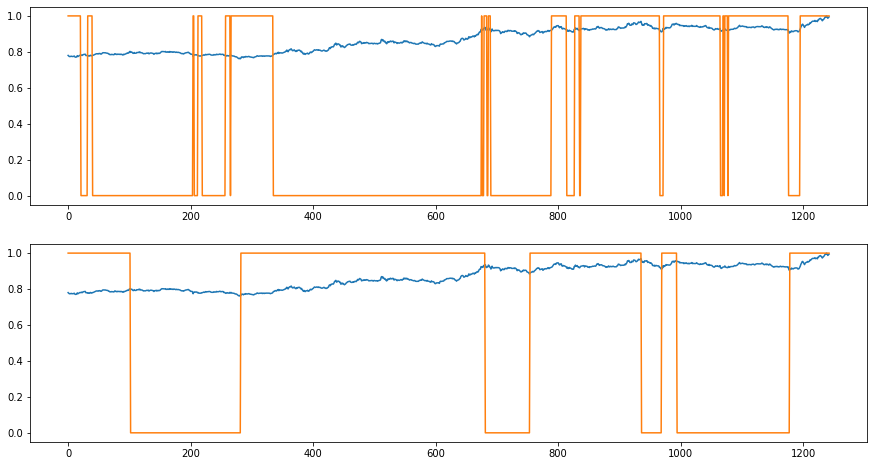

In [ ]:
ohlcv_excel = pd.read_excel(file_path + files[1], index_col=0)

new_column = ['open', 'close', 'high', 'low', 'MA_SHORT', 'MA_LONG', 'SUPERTREND',
                  'TRIX', 'MACD', 'MACD_Signal', 'MACD_OSC', 'FISHER_LONG', 'FISHER_LONGER',
                  'STOCHASTIC_D', 'STOCHASTIC_D2', 'STOCH_RSI', 'STOCH_RSI2', 'STOCH_RSI3', 'LT_Trend']

ohlcv_excel['LT_Trend'] = np.where(ohlcv_excel['LT_Trend'] == 'Bull', 1, 0)

ohlcv_excel = ohlcv_excel[new_column]
# ohlcv_excel = ohlcv_excel.fillna(3)
# print(ohlcv_excel)

ohlcv_excel = ohlcv_excel.iloc[sum(ohlcv_excel['STOCH_RSI3'].isna()):, :]
if sum(sum(np.isnan(ohlcv_excel.values[:, :-1]))) != 0:
    print('None value imported')
    print(sum(np.isnan(ohlcv_excel.values[:, :-1])))

    # print(ohlcv_excel.info())
    # quit()
    # ohlcv_excel.to_excel('test.xlsx')

# NaN 제외하고 데이터 자르기 (데이터가 PIXEL 로 들어간다고 생각하면 된다)
ohlcv_data = ohlcv_excel.values.astype(np.float)

def min_max_scaler(x):
    scaled_x = (x - x.min()) / (x.max() - x.min())
    return scaled_x


def max_abs_scaler(x):
    scaled_x = x / abs(x).max()
    return scaled_x

#        PRICE MA SUPERTREND      #
# ohlcv_data[:, [0, 1, 2, 3, 4, 5, 6]] = min_max_scaler(ohlcv_data[:, [0, 1, 2, 3, 4, 5, 6]])
ohlcv_data[:, [0, 1, 2, 3, 4, 5, 6]] = max_abs_scaler(ohlcv_data[:, [0, 1, 2, 3, 4, 5, 6]])
# ohlcv_data[:, :4] = max_abs_scaler(ohlcv_data[:, :4])

#       TRIX / FISHER   7, 11, 12    #
for column_number in [7, 11, 12]:
    ohlcv_data[:, [column_number]] = max_abs_scaler(ohlcv_data[:, [column_number]])

#       STOCH SERIES     #
for column_number in [10, 13, 14, 15, 16, 17]:
    ohlcv_data[:, [column_number]] = max_abs_scaler(ohlcv_data[:, [column_number]])

#       MACD, SIGNAL   8, 9      #
ohlcv_data[:, [8, 9]] = max_abs_scaler(ohlcv_data[:, [8, 9]])

# X = ohlcv_data[:, :-1]
X = ohlcv_data[:, :4]
y = ohlcv_data[:, [-1]]
print(X.shape, y.shape)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.subplot(211)
plt.plot(X[:, [1]])
plt.plot(best_model.predict(X))

plt.subplot(212)
plt.plot(X[:, [1]])
plt.plot(y)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "red")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

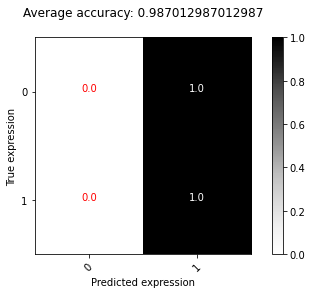

In [ ]:
t_te = y_test.reshape(-1, )
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=np.array(('0', '1', )),
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

### FEATURE IMPORTANCE

Feature: open, Score: 0.04951
Feature: close, Score: 0.08319
Feature: high, Score: 0.05194
Feature: low, Score: 0.03818
Feature: MA_SHORT, Score: 0.05997
Feature: MA_LONG, Score: 0.02671
Feature: SUPERTREND, Score: 0.02214
Feature: TRIX_Histogram, Score: 0.10859
Feature: MACD, Score: 0.13646
Feature: MACD_Signal, Score: 0.07794
Feature: MACD_OSC, Score: 0.08817
Feature: FISHER_LONG, Score: 0.09022
Feature: STOCHASTIC_D, Score: 0.07591
Feature: STOCH_RSI, Score: 0.09108


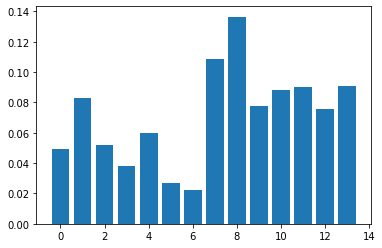

In [33]:
# decision tree for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
# define dataset
# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (new_column[i],v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### RNN Prediction

In [ ]:
import pandas as pd
import numpy as np

input_data_length = 'None'
model_num = 132

X = np.load('Made_X/Made_X %s_%s.npy' % (input_data_length, model_num))
y = np.load('Made_X/Made_Y %s_%s.npy' % (input_data_length, model_num))
print(X.shape, y.shape)


(30162, 18) (30162, 1)


In [ ]:
# X = X.reshape(-1, 18)
X = X[:, :4]
print(X.shape, y.shape)

(30162, 4) (30162, 1)
